In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.preprocessing import StandardScaler

### Exploratory Data Analysys

In [41]:
data_path = "top100.csv"
df = pd.read_csv(data_path)

df.head()

,Position,Const,Created,Modified,Description,Title,Original Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors
0,1,tt0068646,2012-12-21,2017-03-28,Actors: 5 Stars Direction: 5 Stars Screenplay:...,The Godfather,The Godfather,https://www.imdb.com/title/tt0068646/,Movie,9.2,175,1972,"Crime, Drama",2107434,1972-03-24,Francis Ford Coppola
1,2,tt0111161,2012-12-21,2017-03-26,Actors: 4.8 Stars Direction: 5 Stars Screenpla...,The Shawshank Redemption,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/,Movie,9.3,142,1994,Drama,3019758,1994-10-14,Frank Darabont
2,3,tt0108052,2012-12-21,2017-03-26,Actors: 4.9 Stars Direction: 5 Stars Screenpla...,Schindler's List,Schindler's List,https://www.imdb.com/title/tt0108052/,Movie,9.0,195,1993,"Biography, Drama, History",1511813,1994-02-04,Steven Spielberg
3,4,tt0081398,2012-12-21,2017-03-26,Actors: 5 Stars Direction: 5 Stars Screenplay:...,Raging Bull,Raging Bull,https://www.imdb.com/title/tt0081398/,Movie,8.1,129,1980,"Biography, Drama, Sport",393315,1980-12-19,Martin Scorsese
4,5,tt0034583,2012-12-21,2017-03-26,Actors: 5 Stars Direction: 5 Stars Screenplay:...,Casablanca,Casablanca,https://www.imdb.com/title/tt0034583/,Movie,8.5,102,1942,"Drama, Romance, War",627818,1943-01-23,Michael Curtiz


In [42]:
# Check for duplicate rows
print("Number of duplicate rows:", df.duplicated().sum())

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

Number of duplicate rows: 0
Missing values per column:
 Position          0
Const             0
Created           0
Modified          0
Description       0
Title             0
Original Title    0
URL               0
Title Type        0
IMDb Rating       0
Runtime (mins)    0
Year              0
Genres            0
Num Votes         0
Release Date      0
Directors         0
dtype: int64


In [43]:
# Count differences between Title and Original Title
differ = df[df['Title'] != df['Original Title']]
differences = (df['Title'] != df['Original Title']).sum()
print("Number of rows where Title differs from Original Title:", differences)
differ[['Title','Original Title']]

Number of rows where Title differs from Original Title: 3


,Title,Original Title
19,Star Wars: Episode IV - A New Hope,Star Wars
53,"The Good, the Bad and the Ugly","Il buono, il brutto, il cattivo"
62,Goodfellas,GoodFellas


In [ ]:
# lowercase the Title column
# df['Title'] = df['Title'].str.lower()

In [45]:
import re

# Function to parse Description
def parse_description(desc):
    data = {
        'Actors_Stars': 0, 'Direction_Stars': 0, 'Screenplay_Stars': 0,
        'Oscars': 0, 'Oscar_Nominations': 0, 'BAFTA_Awards': 0,
        'BAFTA_Nominations': 0, 'Golden_Globes': 0, 'Golden_Globe_Nominations': 0
    }
    patterns = {
        'Actors_Stars': r"Actors: (\d+\.?\d*) Stars",
        'Direction_Stars': r"Direction: (\d+\.?\d*) Stars",
        'Screenplay_Stars': r"Screenplay: (\d+\.?\d*) Stars",
        'Oscars': r"Oscars: (\d+)",
        'Oscar_Nominations': r"Oscar Nominations: (\d+)",
        'BAFTA_Awards': r"BAFTA Awards: (\d+)",
        'BAFTA_Nominations': r"BAFTA Nominations: (\d+)",
        'Golden_Globes': r"Golden Globes: (\d+)",
        'Golden_Globe_Nominations': r"Golden Globe Nominations: (\d+)"
    }
    for key, pattern in patterns.items():
        match = re.search(pattern, desc)
        if match:
            data[key] = float(match.group(1)) if 'Stars' in key else int(match.group(1))
    return data

# Apply parsing and add new columns
parsed_data = df['Description'].apply(parse_description).apply(pd.Series)
df = pd.concat([df, parsed_data], axis=1)
parsed_data.head()

,Actors_Stars,Direction_Stars,Screenplay_Stars,Oscars,Oscar_Nominations,BAFTA_Awards,BAFTA_Nominations,Golden_Globes,Golden_Globe_Nominations
0,5.0,5.0,5.0,3.0,11.0,0.0,4.0,6.0,8.0
1,4.8,5.0,4.9,0.0,7.0,0.0,0.0,0.0,2.0
2,4.9,5.0,5.0,7.0,12.0,6.0,12.0,3.0,6.0
3,5.0,5.0,5.0,2.0,8.0,2.0,4.0,1.0,7.0
4,5.0,5.0,5.0,3.0,8.0,0.0,0.0,0.0,0.0


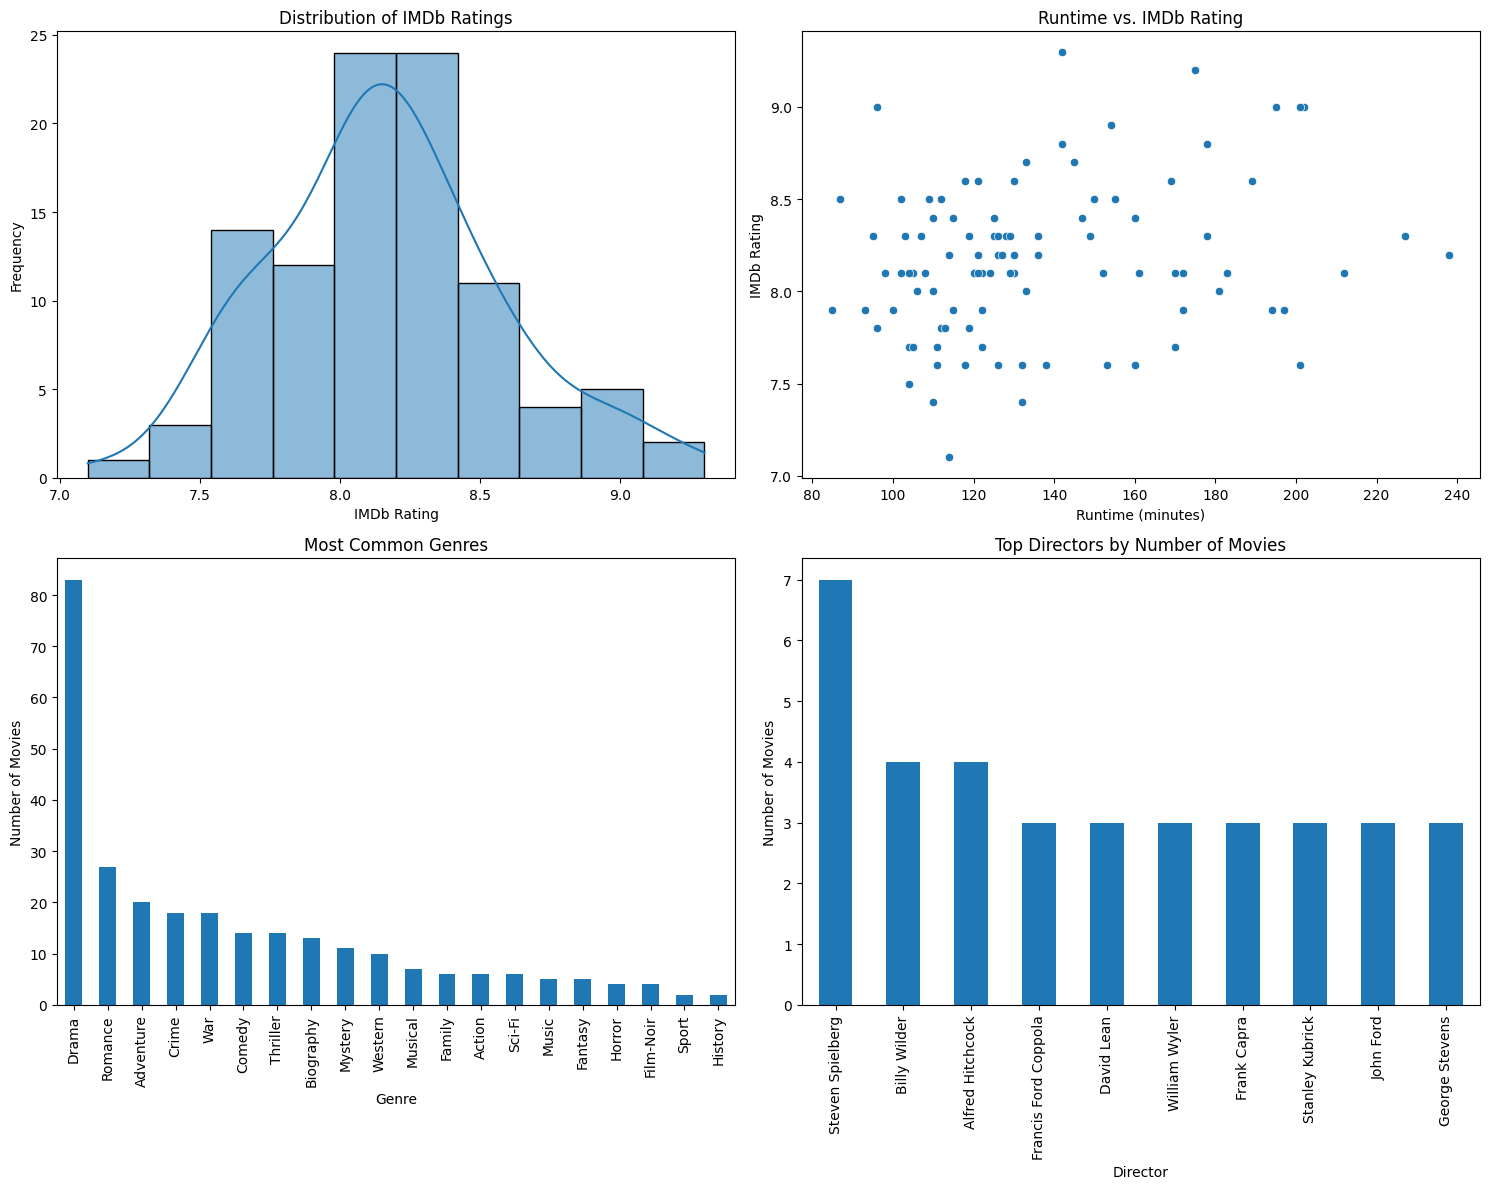

In [46]:
plt.figure(figsize=(15, 12))

# Histogram of IMDb ratings
plt.subplot(2, 2, 1)
sns.histplot(df['IMDb Rating'], bins=10, kde=True)
plt.title('Distribution of IMDb Ratings')
plt.xlabel('IMDb Rating')
plt.ylabel('Frequency')

# Scatter plot of Runtime vs. IMDb Rating
plt.subplot(2, 2, 2)
sns.scatterplot(x='Runtime (mins)', y='IMDb Rating', data=df)
plt.title('Runtime vs. IMDb Rating')
plt.xlabel('Runtime (minutes)')
plt.ylabel('IMDb Rating')

# Split and explode Genres
df['Genres'] = df['Genres'].str.split(', ')
all_genres = df.explode('Genres')['Genres'].value_counts()

# Bar chart of genre frequencies
plt.subplot(2, 2, 3)
all_genres.plot(kind='bar')
plt.title('Most Common Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')

# Count movies per director
director_counts = df['Directors'].value_counts()

# Bar chart of top directors
plt.subplot(2, 2, 4)
director_counts.head(10).plot(kind='bar')
plt.title('Top Directors by Number of Movies')
plt.xlabel('Director')
plt.ylabel('Number of Movies')

# Show all the plots at once
plt.tight_layout()
plt.show()

Correlation Matrix:
                   Actors_Stars  Direction_Stars  Screenplay_Stars  IMDb Rating
Actors_Stars          1.000000         0.610002          0.738412     0.340899
Direction_Stars       0.610002         1.000000          0.726515     0.496777
Screenplay_Stars      0.738412         0.726515          1.000000     0.422816
IMDb Rating           0.340899         0.496777          0.422816     1.000000


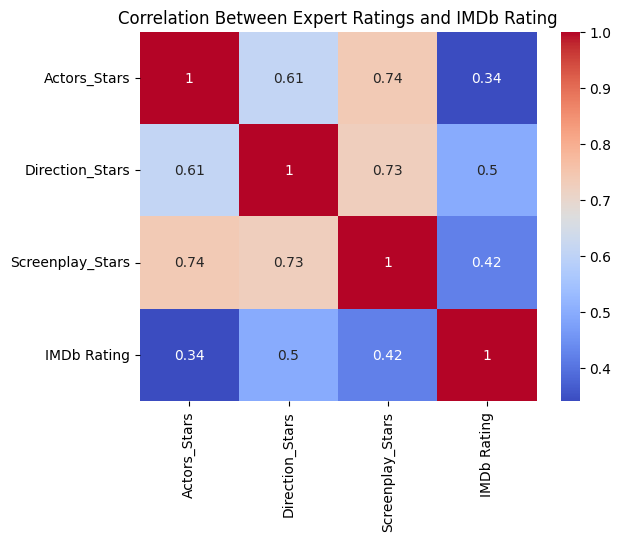

In [47]:
# Correlation matrix
correlations = df[['Actors_Stars', 'Direction_Stars', 'Screenplay_Stars', 'IMDb Rating']].corr()

# Display and visualize
print("Correlation Matrix:\n", correlations)
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Between Expert Ratings and IMDb Rating')
plt.show()

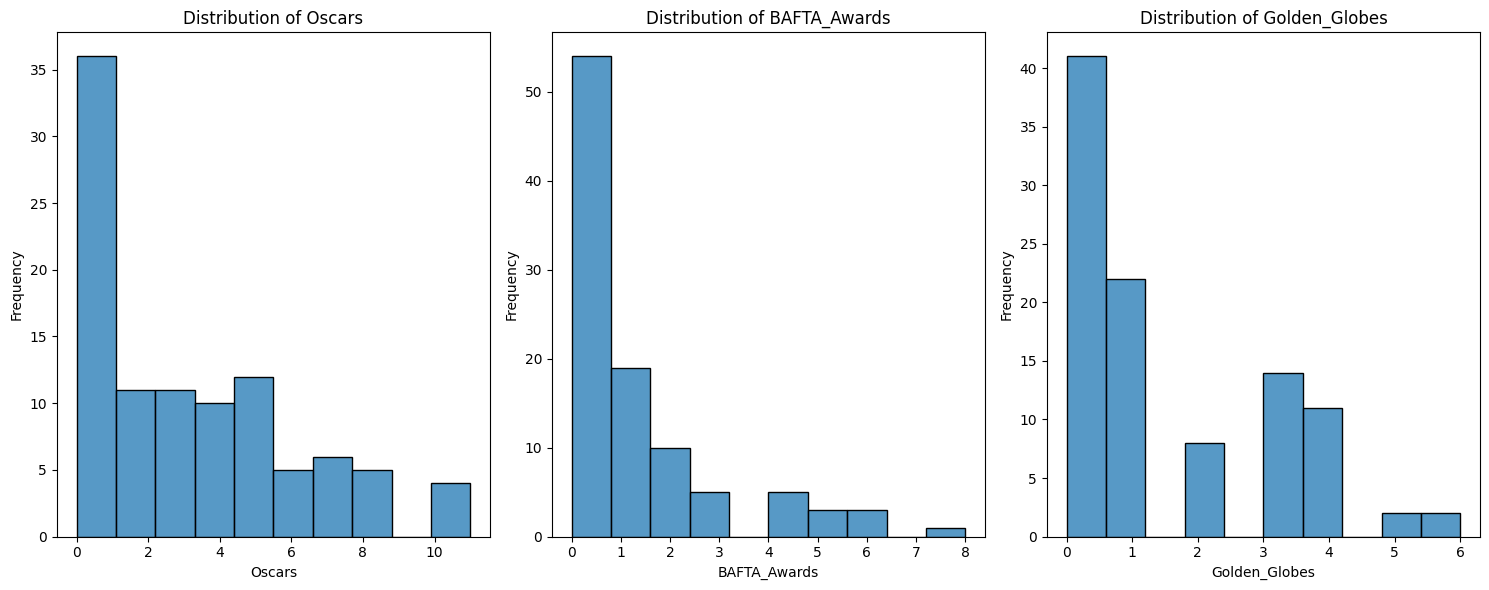

In [48]:
# Histograms for award wins
award_columns = ['Oscars', 'BAFTA_Awards', 'Golden_Globes']

plt.figure(figsize=(15, 6))

for i,col in enumerate(award_columns):
    plt.subplot(1, 3,i+1)
    sns.histplot(df[col], bins=10, kde=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

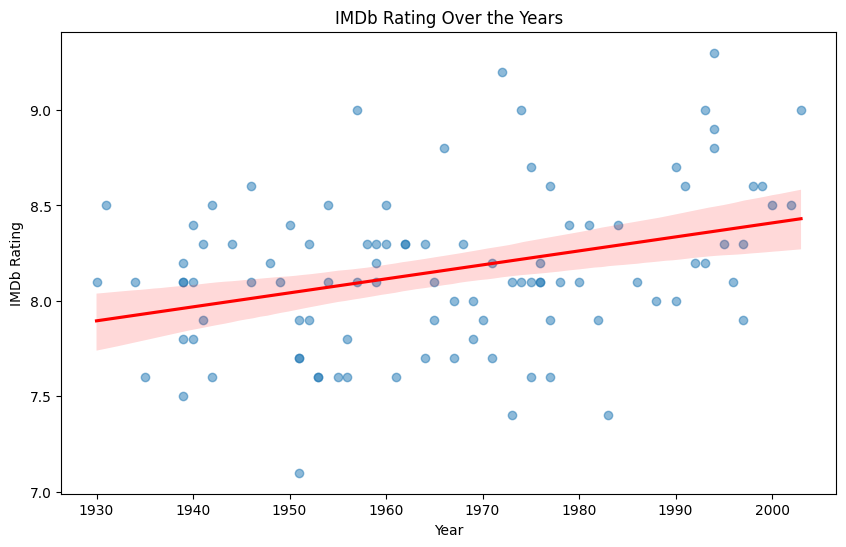

In [49]:
# Scatter plot with trend line
plt.figure(figsize=(10, 6))
sns.regplot(x='Year', y='IMDb Rating', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('IMDb Rating Over the Years')
plt.xlabel('Year')
plt.ylabel('IMDb Rating')
plt.show()

### Data Preprocessing

In [50]:
# One-hot encode the genres using `get_dummies`
df_genres = df['Genres'].explode().str.get_dummies().groupby(level=0).sum()

# Add the one-hot encoded genres back to the dataframe
df = pd.concat([df, df_genres], axis=1)

In [51]:
# Normalize IMDb Rating and Runtime
# scaler = MinMaxScaler()
# df[['IMDb Rating', 'Runtime (mins)']] = scaler.fit_transform(df[['IMDb Rating', 'Runtime (mins)']])

In [52]:
df.columns

Index(['Position', 'Const', 'Created', 'Modified', 'Description', 'Title',
       'Original Title', 'URL', 'Title Type', 'IMDb Rating', 'Runtime (mins)',
       'Year', 'Genres', 'Num Votes', 'Release Date', 'Directors',
       'Actors_Stars', 'Direction_Stars', 'Screenplay_Stars', 'Oscars',
       'Oscar_Nominations', 'BAFTA_Awards', 'BAFTA_Nominations',
       'Golden_Globes', 'Golden_Globe_Nominations', 'Action', 'Adventure',
       'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy',
       'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

In [53]:
feature_columns = [
    'IMDb Rating', 'Runtime (mins)', 'Year', 'Actors_Stars', 'Direction_Stars', 'Screenplay_Stars',
    'Oscars', 'Oscar_Nominations', 'BAFTA_Awards', 'BAFTA_Nominations', 'Golden_Globes', 'Golden_Globe_Nominations', 'Action', 'Adventure', 'Biography', 'Comedy', 'Crime', 'Drama','Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']

feature_matrix = df[feature_columns]

In [54]:
X = feature_matrix.values

# Normalize the data (important for cosine similarity)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(X_scaled)

# Create a DataFrame with similarity scores (for all pairs of movies)
# This matrix represents the similarity between all pairs of movies
similarity_df = pd.DataFrame(cosine_sim_matrix, columns=df['Title'], index=df['Title'])

In [55]:
movie_pairs = []
similarity_labels = []

for i in range(len(df)):
    for j in range(i + 1, len(df)):  # Only consider pairs (i, j) where i < j
        movie_pair = np.concatenate([X_scaled[i], X_scaled[j]])  # Concatenate the two feature vectors into one
        movie_pairs.append(movie_pair)  # Add to the list of movie pairs
        similarity_labels.append(cosine_sim_matrix[i, j])  # Cosine similarity score for this pair

# Convert to numpy arrays
movie_pairs = np.array(movie_pairs)
similarity_labels = np.array(similarity_labels)

In [56]:
# Assuming your preprocessed dataset is in the `df` DataFrame
df.to_csv('preprocessed_dataset.csv', index=False)

### Model

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
# Define the model
model = Sequential()

# Add layers to the model
model.add(Dense(128, input_dim=2 * X_scaled.shape[1], activation='relu')) 
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
model.fit(movie_pairs, similarity_labels, epochs=50, batch_size=32)

# Save the trained model for future use
model.save('movie_similarity_model.h5')


Epoch 1/50


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - loss: 0.0971 - mae: 0.2296
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.0212 - mae: 0.1126
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 0.0134 - mae: 0.0896
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 0.0094 - mae: 0.0757
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mae: 0.0650
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 0.0056 - mae: 0.0588
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.0041 - mae: 0.0502
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.0037 - mae: 0.0479
Epoch 9/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 0.0031 - mae: 0.0439
Epoch 10/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.0029 - mae: 0.0420
Epoch 11/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.0025 - mae: 0.0393
Epoch 12/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022 - mae: 0.0367
Epoch 13/50
155/

In [59]:
# Load the trained model
model = tf.keras.models.load_model('movie_similarity_model.h5')

# Get the features of the selected movie (e.g., "The Godfather")
selected_movie_name = "The Godfather"
selected_movie = df[df['Title'] == selected_movie_name.lower()]
selected_movie_features = selected_movie[feature_columns].values
selected_movie_features_scaled = scaler.transform(selected_movie_features)

# Predict similarity to all other movies
similarity_scores = []

for i in range(len(df)):
    movie_features = X_scaled[i]
    
    # Concatenate selected movie's features with all other movies' features
    pair_features = np.concatenate([selected_movie_features_scaled.flatten(), movie_features.flatten()])
    
    # If the selected movie is being compared to itself, assign 1.0 similarity score
    if df['Title'].iloc[i] == selected_movie_name:
        similarity_scores.append(1.0)
    else:
        # Otherwise, use the trained model to predict the similarity score for this pair
        predicted_similarity = model.predict(pair_features.reshape(1, -1))
        similarity_scores.append(predicted_similarity[0][0])

# Rank the movies based on similarity
similarity_df = pd.DataFrame({
    'Title': df['Title'],
    'Similarity Score': similarity_scores
})

top_5_similar_movies = similarity_df.sort_values(by='Similarity Score', ascending=False).head(6)[1:]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [61]:
top_5_similar_movies

,Title,Similarity Score
12,the godfather part ii,0.656022
8,one flew over the cuckoo's nest,0.559277
15,forrest gump,0.546979
84,pulp fiction,0.546598
13,on the waterfront,0.499462


In [ ]:
df['Genres'].head(10)

0                           [Crime, Drama]
1                                  [Drama]
2              [Biography, Drama, History]
3                [Biography, Drama, Sport]
4                    [Drama, Romance, War]
5                         [Drama, Mystery]
6                    [Drama, Romance, War]
7    [Adventure, Family, Fantasy, Musical]
8                                  [Drama]
9       [Adventure, Biography, Drama, War]
Name: Genres, dtype: object

In [ ]:
# Step 1: Apply Genre Filter
genre_filter = ["Drama"]  # User wants movies with Drama and Crime genres
filtered_df = df[df['Genres'].apply(lambda x: all(genre in x for genre in genre_filter))]

# Step 2: Apply other filters (e.g., IMDb rating, runtime)
rating_range = (7.0, 9.0)  # IMDb rating between 7.0 and 9.0
filtered_df = filtered_df[(filtered_df['IMDb Rating'] >= rating_range[0]) & (filtered_df['IMDb Rating'] <= rating_range[1])]

runtime_range = (90, 150)  # Movies with runtime between 90 and 150 minutes
filtered_df = filtered_df[(filtered_df['Runtime (mins)'] >= runtime_range[0]) & (filtered_df['Runtime (mins)'] <= runtime_range[1])]

# Step 3: Use the one-hot encoded genre columns and other features for model predictions
filtered_movie_features = filtered_df[feature_columns].values
filtered_movie_features_scaled = scaler.transform(filtered_movie_features)

# Predict similarity scores
similarity_scores = []
for i in range(len(filtered_df)):
    movie_features = filtered_movie_features_scaled[i]
    pair_features = np.concatenate([selected_movie_features_scaled.flatten(), movie_features.flatten()])
    predicted_similarity = model.predict(pair_features.reshape(1, -1))
    similarity_scores.append(predicted_similarity[0][0])

# Step 4: Rank movies based on similarity score
similarity_df = pd.DataFrame({
    'Title': filtered_df['Title'],
    'Similarity Score': similarity_scores
})

# Return top 5 similar movies
top_5_similar_movies = similarity_df.sort_values(by='Similarity Score', ascending=False).head(5)
print(top_5_similar_movies)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━